# Final Submission for Mod 2 Project
Created by Albert Um Data Science Cohort 06/22/20

Using Linear Regression to find variables that explain the target, Baby Weight.

The notebook contains the following:
1. Data Preprocessing
2. Visualizations with Statistical Tests
3. Model Approach
4. Key Insights


# 1. Data Preprocessing
The dataset has 3.8 million rows with 55 columns. Please use an appropriate sample size before plotting. <br>
I will first need to transform some of the integer-like categorical values. The keys are located in 'US_Birth_columns' text file. <br>
In addition, I will need to engineer new variables to better enhance the R2 score.

### Libraries to import:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
%matplotlib inline

pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

### Import Data:

In [2]:
df = pd.read_csv('../US_births.csv', low_memory=False)
df = df.sample(n=250_000, random_state=42)
df.shape

(250000, 55)

### Dropping Rows:
Unfortunately, we will have to drop some continuous variables that are 'Unknown' or 'Not available'. <br>
For more information about the columns and it's values, look to US_Birth_columns.

In [3]:
def drop_rows(df):
    '''
    Dropping rows where missing: 'DBWT', 'BMI', 'DBWT', 'WTGAIN', 'PWgt_R', 'DLMP_MM', 'DLMP_YY'
    '''
    df.drop(df[df['DBWT'].eq(9999)].index, inplace=True)    
    df.drop(df[df['BMI'].eq(99.9)].index, inplace=True)
    df.drop(df[df['DBWT'].eq(9999)].index, inplace=True)
    df.drop(df[df['WTGAIN'].eq(99)].index, inplace=True)
    df.drop(df[df['PWgt_R'].eq(999)].index, inplace=True)
    df.drop(df[df['DLMP_MM'].eq(99)].index, inplace=True)
    df.drop(df[df['DLMP_YY'].eq(9999)].index, inplace=True)
    
    df.drop(columns=['IMP_SEX'], inplace=True)
    return df


In [4]:
df = drop_rows(df)
df.shape

(231493, 54)

### Feature Engineering:
As well as transforming the integer-like categorical values to objects, I will create some new features that can help my r2 score.<br>
I have chosen not to drop the rows with unknown categorical values. I'll treat them as it's own class.

In [5]:
def feature_engineer(df):
    '''
    Creating new column: 'first_birth', 'smoked', 'PRIORDEAD_cat', 'PRIORTERM_cat', 'PRIORLIVE_cat', 
    
    '''

    #creating new column called 'first_birth': Is the baby the Mom's first child? Yes:1 No:0
    df['first_birth'] = np.where(df['ILLB_R'].eq(888), 1, 0)
    df['plural_delivery'] = np.where(df['ILLB_R'].lt(4), 'Yes', 'No')


    
    #creating new column 'smoked': Did the mother smoke before pregnancy? Yes: Daily, No: None, Unknown: Unknown
    conditions = [df['CIG_0'].eq(0),
                  df['CIG_0'].eq(99)]
    choices = ['None',
               'Unknown']
    df['smoked'] = np.select(conditions, choices, 'Daily')

    
    #creating new column 'PRIORDEAD_cat': Did the mother previously have miscarriages? Yes: Yes, No: None, Unknown: Unknown
    conditions = [df['PRIORDEAD'].eq(0),
                  df['PRIORDEAD'].eq(99)]
    choices = ['None',
               'Unknown']
    df['PRIORDEAD_cat'] = np.select(conditions, choices, 'Yes')

    
    #creating new column 'PRIORTERM_cat': Did the mother previously have terminations? Yes: Yes, No:None, Unknown: Unknown
    conditions = [df['PRIORTERM'].eq(0),
                  df['PRIORTERM'].eq(99)]
    choices = ['None',
               'Unknown']
    df['PRIORTERM_cat'] = np.select(conditions, choices, 'Yes')

    #creating new column 'PRIORLIVE_cat': Did the mother previously birth living children: Yes: Yes, No: None, Unknown: Unknown
    conditions = [df['PRIORLIVE'].eq(0),
                  df['PRIORLIVE'].eq(99)]
    choices = ['None',
               'Unknown']
    df['PRIORLIVE_cat'] = np.select(conditions, choices, 'Yes')

    #creating new column 'pregnancy_length': An estimation of the gestation period by subtracting the month/year of last menses from month/year of baby born
    conditions = [(df['DOB_MM'] > df['DLMP_MM']) & (2018 == df['DLMP_YY']),
                  (df['DOB_MM'] > df['DLMP_MM']) & (2018 > df['DLMP_YY']),
                  (df['DOB_MM'] < df['DLMP_MM']) & (2018 > df['DLMP_YY'])]
    choices = [df['DOB_MM'] - df['DLMP_MM'],
               ((df['DOB_YY'] - df['DLMP_YY'])* 12) + df['DOB_MM'] - df['DLMP_MM'],
               ((df['DOB_YY'] - df['DLMP_YY'])* 12) - df['DLMP_MM'] + df['DOB_MM']]
    df['pregnancy_length'] = np.select(conditions,choices, 12)
    
    #creating new column 'MAGER_cat': Mother's age is < 18: Minor, Mother's age is >= 18: Adult
    df['MAGER_cat'] = np.where(df['MAGER'].lt(18),'Minor','Adult')

    #creating new column 'pregnancy_cat: Binning pregnancy_length to 5 bins: 'Early','8','9','10','Late'
    condition =[df['pregnancy_length'].eq(9),
                df['pregnancy_length'].eq(8),
                df['pregnancy_length'].eq(10),
                df['pregnancy_length'].lt(7)]
    choices = ['9',
              '8',
               '10',
               'Early']
    df['pregnancy_length_cat'] = np.select(condition,choices, 'Late')

    #creating new column 'BMI_log':np.log(BMI) to normalize BMI
    df['BMI_log'] = np.log(df['BMI'])
    
    #creating new column 'first_pregnancy': Is it mother's first live birth? Yes: 1, No: 0
    df['first_live_birth'] = np.where(df['ILP_R'].eq(888), 1, 0)
    
    #creating new column 'first_natal': Is it mother's first natality event? Yes: 1, No: 0
    df['first_natal'] = np.where(df['ILOP_R'].eq(888),1, 0)
    
    #adjusting 'PRECARE' values: if Unkonwn, impute 0
    df['PRECARE'] = np.where(df['PRECARE'].eq(99), 0, df['PRECARE'])
    
    #adjusting 'PREVIS' values: if Unkonwn, impute 0
    df['PREVIS'] = np.where(df['PREVIS'].eq(99), 0, df['PREVIS'])
    
    #creating new column 'T35AGE_older': Is mother's age older than 34? Yes: 1, No: 0
    df['T35AGE_older'] = np.where(df['MAGER'].gt(34), 1, 0)
    
    #creating new column 'MOM_weight': manually computing mom's weight incase of missing values
    df['MOM_weight'] = (df['M_Ht_In']**2)*df['BMI']/704
    
    #creating new column '...': Weight gained divided by Mom's Weight
    df['WTGAIN_div_MOM_weight'] = df['WTGAIN']/df['MOM_weight']
    
    #creating new column '...': Weight gained divided by gestation period
    df['WTGAIN_div_length'] = df['WTGAIN'] / df['pregnancy_length']
    
    #creating new column '...': calculating percentage of weight gained due to pregnancy
    df['WT_percent_gain'] = df['WTGAIN'] / df['PWgt_R']
    
    #adjusting 'MAR_IMP': Marriage imputed should be 0 if left blank
    df['MAR_IMP'] = np.where(df['MAR_IMP'].eq(' '),0,1)
    
    #adjusting 'DMAR': assigning blanks to a new variable 0 for unknowns
    df['DMAR'] = np.where(df['DMAR'].eq(' '),0,df['DMAR'])
    
    #creating new column '...': 
    df['pregnancy_length_sqrt'] =  np.sqrt(df['pregnancy_length'])
    
    #dropping rows that with gestation period greater than 12 and less than 5, treating them as outliers
    df.drop(df[df['pregnancy_length'].gt(12)].index,inplace=True)
    df.drop(df[df['pregnancy_length'].lt(5)].index,inplace=True)
    return df


In [6]:
df = feature_engineer(df)
df.reset_index(inplace=True,drop=True)
df.shape

(230879, 72)

### Handing picking:
From here, I hand picked the columns that will be used for this model and created dummy variables for the categorical columns.

In [7]:
X = df[['ATTEND','BFACIL', 'smoked', 'DOB_MM', 'DMAR','FHISPX','FEDUC', 'FRACE6', 'first_birth', 'plural_delivery', 'first_live_birth', 'first_natal','pregnancy_length_sqrt',
        'IP_GON', 'LD_INDL', 'MAGER', 'T35AGE_older','MAR_IMP', 'MBSTATE_REC', 'MEDUC', 'MHISPX', 'MRAVE6', 'MTRAN', 'pregnancy_length', 'WTGAIN_div_MOM_weight','WTGAIN_div_length',
        'NO_INFEC','NO_MMORB','NO_RISKS','PAY', 'PAY_REC','PRECARE','PREVIS', 'PRIORDEAD_cat', 'PRIORLIVE_cat', 'PRIORTERM_cat', 'PWgt_R', 'BMI_log','M_Ht_In', 'MOM_weight',
        'RDMETH_REC', 'RESTATUS', 'RF_CESAR', 'SEX', 'WTGAIN','WT_percent_gain','MAGER_cat','pregnancy_length_cat','BMI'
]]

_X = pd.get_dummies(X, columns=['ATTEND', 'BFACIL','smoked', 'DOB_MM','DMAR','FHISPX','FEDUC','FRACE6', 'plural_delivery',
                                'IP_GON','LD_INDL', 'T35AGE_older','MAR_IMP', 'MBSTATE_REC', 'MEDUC', 'MHISPX', 'MRAVE6', 'MTRAN',
                                'NO_INFEC','NO_MMORB','NO_RISKS', 'PAY', 'PAY_REC','PRIORDEAD_cat', 'PRIORLIVE_cat','PRIORTERM_cat',
                                'RDMETH_REC', 'RESTATUS', 'RF_CESAR', 'SEX','MAGER_cat','pregnancy_length_cat']).copy()
y = df['DBWT']
_X.shape

(230879, 168)

### Feature Engineering on Dummies:
I also want interactions between the dummy variables and the variables created from the first round of feature engineering

In [8]:
def feat_eng_dummy(_X):
    _X['MAGER_smoked_Daily'] = _X['MAGER'] * _X['smoked_Daily']
    _X['NO_RISKS_1_length'] = _X['NO_RISKS_1'] * _X['pregnancy_length']
    _X['RDMETH_REC_3_length'] = _X['RDMETH_REC_3'] * _X['pregnancy_length']
    _X['RDMETH_REC_1_length'] = _X['RDMETH_REC_1'] * _X['pregnancy_length']
    _X['ATTEND_1_length'] = _X['pregnancy_length'] * _X['ATTEND_1']
    _X['MRAVE6_1_FRACE6_1'] = _X['MRAVE6_1'] * _X['FRACE6_1']
    _X['BFACIL_1_length'] = _X['pregnancy_length'] * _X['BFACIL_1']
    _X['BMI_log_length'] = _X['BMI_log'] * _X['pregnancy_length']
    _X['M_Ht_In_length'] = _X['DMAR_1'] * _X['pregnancy_length']
    _X['LD_INDL_N_length'] = _X['LD_INDL_N'] * _X['pregnancy_length']
    _X['MTRAN_Y_length'] = _X['MTRAN_Y'] * _X['pregnancy_length']
    _X['PRECARE_length'] = _X['PRECARE'] * _X['pregnancy_length']
    _X['PREVIS_length'] = _X['PREVIS'] * _X['pregnancy_length']
    _X['MOM_weight_length'] = _X['MOM_weight'] * _X['pregnancy_length']
    _X['RDMETH_REC_3_pregnancy_length_cat_9'] = _X['RDMETH_REC_3'] * _X['pregnancy_length_cat_9']
    _X['RF_CESAR_Y_pregnancy_length_cat_9'] = _X['RF_CESAR_Y'] * _X['pregnancy_length_cat_9']
    
    return _X

In [9]:
_X = feat_eng_dummy(_X)
_X.shape

(230879, 184)

### Assigning column lists:
creating a list of continuous columns will help us when we want to scale only our contious variables

In [10]:

_X_columns = _X.columns
categorical_columns = []
continuous_columns = []
for i in _X_columns:
    if _X[i].max() == 1:
        categorical_columns.append(i)
    else:
        continuous_columns.append(i)
        
del _X_columns

# 2. Visualizations with Statistical Tests
I will do some statistical tests for categorical independent features to see if there is a difference in baby weight
1. Two Sample T-test by Gender of Baby
2. Two Sample T-test by Mother who has smoked vs not smoked
3. ANOVA test for Mothers of different race
4. ANOVA test for Mothers with different gestations periods

### Distribution of plot of target variable, Baby Weight
The distribution of Baby Weight (in Grams) looks somewhat normal. I won't need to transform the dependent variable.

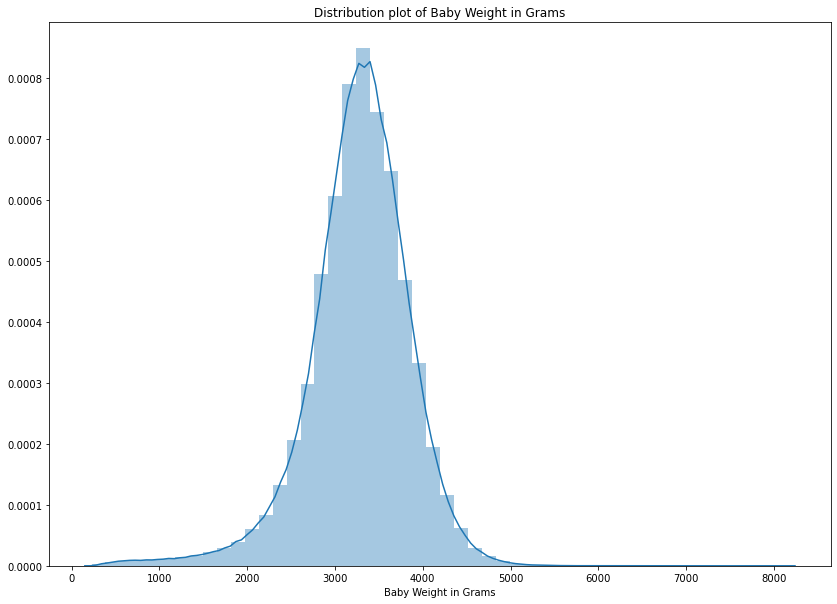

In [11]:
_X['DBWT'] = y
plt.figure(figsize=(14,10))
sns.distplot(_X['DBWT'])
plt.title('Distribution plot of Baby Weight in Grams')
plt.xlabel('Baby Weight in Grams')
plt.savefig('figure1.png');

### Two sample t test
null hypothesis: Male baby weight = Female baby weight<br>
alternative: Male body weight != Female baby weight

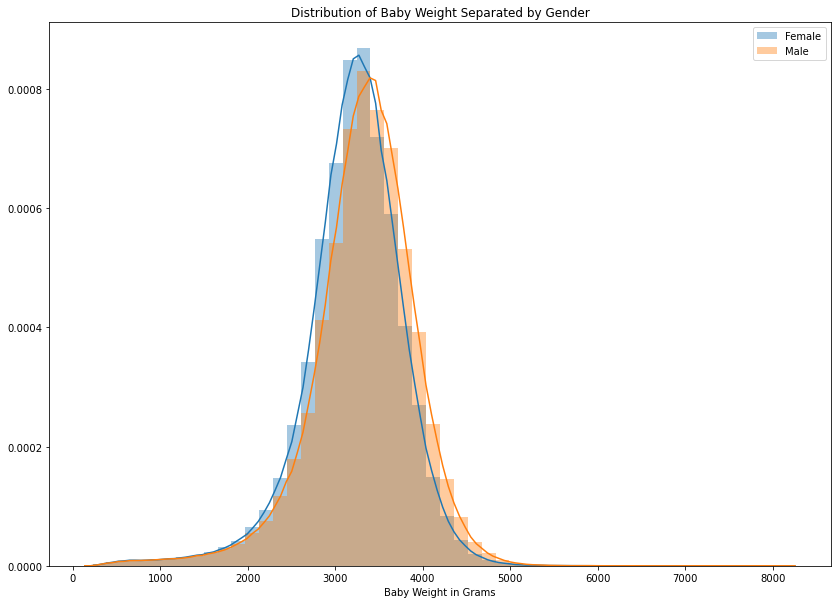

<Figure size 432x288 with 0 Axes>

In [12]:
plt.figure(figsize=(14,10))
sns.distplot(_X[_X['SEX_M'].eq(0)]['DBWT'], label = 'Female')
sns.distplot(_X[_X['SEX_M'].eq(1)]['DBWT'], label = 'Male')
plt.title('Distribution of Baby Weight Separated by Gender')
plt.xlabel('Baby Weight in Grams')
plt.legend()
plt.figure('figure2.png');

In [13]:
# null: Male Baby Weight = Female Baby Weight
# alt: Male Baby Weight != Female Baby Weight
# alpha: 0.05
stats.f_oneway(_X[_X['SEX_M'].eq(0)]['DBWT'],
              _X[_X['SEX_M'].eq(1)]['DBWT'])
# reject null. There is significant evidence to suggest that male babies weigh differently than females.

F_onewayResult(statistic=34730.30669533371, pvalue=0.0)

### Two sample t test
null hypothesis: Moms that never smoked[**baby weight**] = Moms that have smoked[**baby weight**]<br>
alternative: Moms that never smoked[**baby weight**] != Moms that have smoked[**baby weight**]

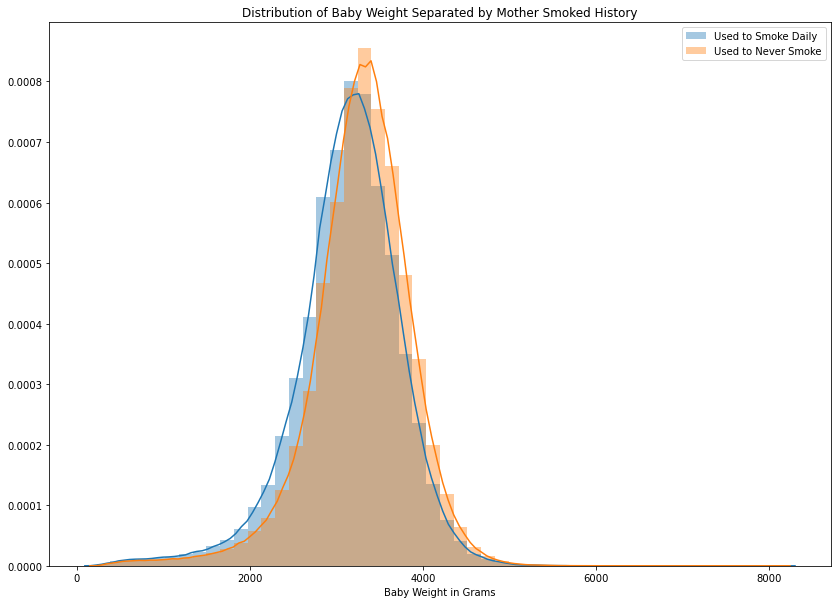

In [14]:
plt.figure(figsize=(14,10))
sns.distplot(_X[_X['smoked_Daily'].eq(1)]['DBWT'], label = 'Used to Smoke Daily')
sns.distplot(_X[_X['smoked_None'].eq(1)]['DBWT'], label = 'Used to Never Smoke')
plt.title('Distribution of Baby Weight Separated by Mother Smoked History')
plt.xlabel('Baby Weight in Grams')
plt.legend()
plt.savefig('figure3.png');

In [15]:
# null: Baby Weight of Moms who used to Smoke Daily = Baby Weight of Moms who never smoked
# alt: Baby Weight of Moms who used to Smoke Daily != Baby Weight of Moms who never smoked
# alpha: 0.05
stats.f_oneway(_X[_X['smoked_Daily'].eq(1)]['DBWT'],
              _X[_X['smoked_None'].eq(1)]['DBWT'])
# reject null. There is significant evidence that moms who used to smoke have different baby weights than those who never smoked.

F_onewayResult(statistic=17277.568424414345, pvalue=0.0)

### ANOVA test
null hypothesis: Baby weights of Moms of different races are equal <Br>
alternative: Baby weights of moms of different are NOT equal

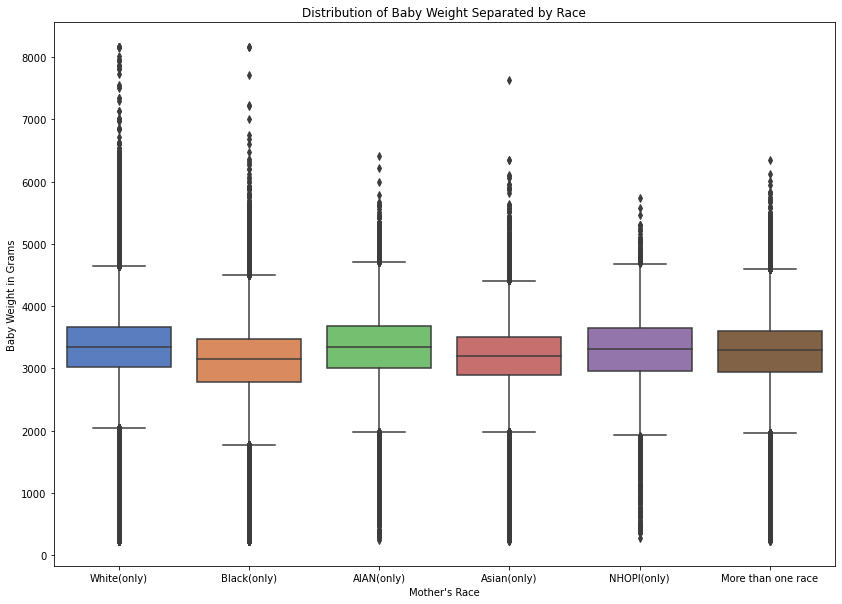

In [16]:
fig, ax = plt.subplots(figsize=(14,10))
sns.boxplot(x='MRAVE6',y='DBWT', data=df, palette='muted')
ax.set_title('Distribution of Baby Weight Separated by Race')
ax.set_xlabel('Mother\'s Race')
ax.set_ylabel('Baby Weight in Grams')
ax.set_xticklabels(['White(only)','Black(only)','AIAN(only)','Asian(only)','NHOPI(only)','More than one race'])
plt.savefig('figure4.png');

In [17]:
# null: Baby Weights of Moms of different Race are equal
# alt: Baby Weights of Moms of different Race are NOT equal
# alpha: 0.05
stats.f_oneway(_X[_X['MRAVE6_1'].eq(1)]['DBWT'],
              _X[_X['MRAVE6_2'].eq(1)]['DBWT'],
              _X[_X['MRAVE6_3'].eq(1)]['DBWT'],
              _X[_X['MRAVE6_4'].eq(1)]['DBWT'],
              _X[_X['MRAVE6_5'].eq(1)]['DBWT'],
              _X[_X['MRAVE6_6'].eq(1)]['DBWT'])
# reject null. There is significant evidence to suggest that the all race babies are not the same.

F_onewayResult(statistic=15918.855016818572, pvalue=0.0)

##### POST-hoc using statsmodels tukeyhsd
Pairing all combinations of Race

In [18]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
_result = pairwise_tukeyhsd(df['DBWT'],df['MRAVE6'], alpha = 0.05/6)
_result._results_table

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-229.4249,0.001,-232.355,-226.4948,True
1,3,0.2252,0.9,-10.7105,11.1609,False
1,4,-146.4726,0.001,-150.6694,-142.2758,True
1,5,-35.7098,0.001,-54.8049,-16.6147,True
1,6,-70.5333,0.001,-77.1179,-63.9486,True
2,3,229.6501,0.001,218.4608,240.8394,True
2,4,82.9523,0.001,78.133,87.7716,True
2,5,193.7151,0.001,174.4736,212.9566,True
2,6,158.8916,0.001,151.8938,165.8895,True
3,4,-146.6978,0.001,-158.2835,-135.1121,True


### ANOVA test
null hypothesis: Baby weights of all gestation periods are equal <br>
alternative: Baby weights of all gestations periods are NOT equal

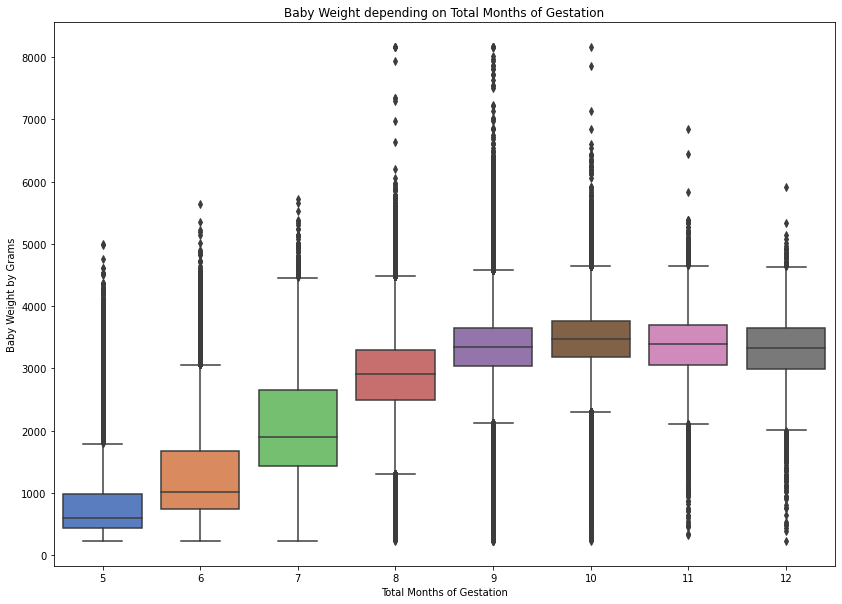

In [19]:
plt.figure(figsize=(14,10))
sns.boxplot(x='pregnancy_length',y='DBWT',data=df, palette = 'muted')
plt.title('Baby Weight depending on Total Months of Gestation')
plt.ylabel('Baby Weight by Grams')
plt.xlabel('Total Months of Gestation')
plt.savefig('figure5.png')

In [20]:
# null: Baby weights of all gestation periods are equal
# alt: Baby weights of all gestation periods are NOT equal
# alpha: 0.05
stats.f_oneway(df[df['pregnancy_length'].eq(5)]['DBWT'],
              df[df['pregnancy_length'].eq(6)]['DBWT'],
              df[df['pregnancy_length'].eq(7)]['DBWT'],
              df[df['pregnancy_length'].eq(8)]['DBWT'],
              df[df['pregnancy_length'].eq(9)]['DBWT'],
               df[df['pregnancy_length'].eq(10)]['DBWT'],
               df[df['pregnancy_length'].eq(11)]['DBWT'],
               df[df['pregnancy_length'].eq(12)]['DBWT'])
# reject null. There is significant evidence to suggest that that the length of gestation has an effect on baby weight

F_onewayResult(statistic=161677.413230604, pvalue=0.0)

##### POST-hoc using statsmodels tukeyhsd
Pairing all combinations of Race

In [21]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
_result = pairwise_tukeyhsd(df['DBWT'],df['pregnancy_length'], alpha = 0.05/8)
_result._results_table

group1,group2,meandiff,p-adj,lower,upper,reject
5,6,321.1199,0.001,295.338,346.9018,True
5,7,979.8106,0.001,956.4297,1003.1916,True
5,8,1800.8116,0.001,1778.5691,1823.0541,True
5,9,2258.9204,0.001,2236.8082,2281.0326,True
5,10,2391.1973,0.001,2368.9642,2413.4305,True
5,11,2281.3933,0.001,2256.0141,2306.7724,True
5,12,2206.6985,0.001,2172.236,2241.161,True
6,7,658.6907,0.001,643.3189,674.0626,True
6,8,1479.6917,0.001,1466.114,1493.2695,True
6,9,1937.8005,0.001,1924.4372,1951.1637,True


### Total Months of Prenatal Care

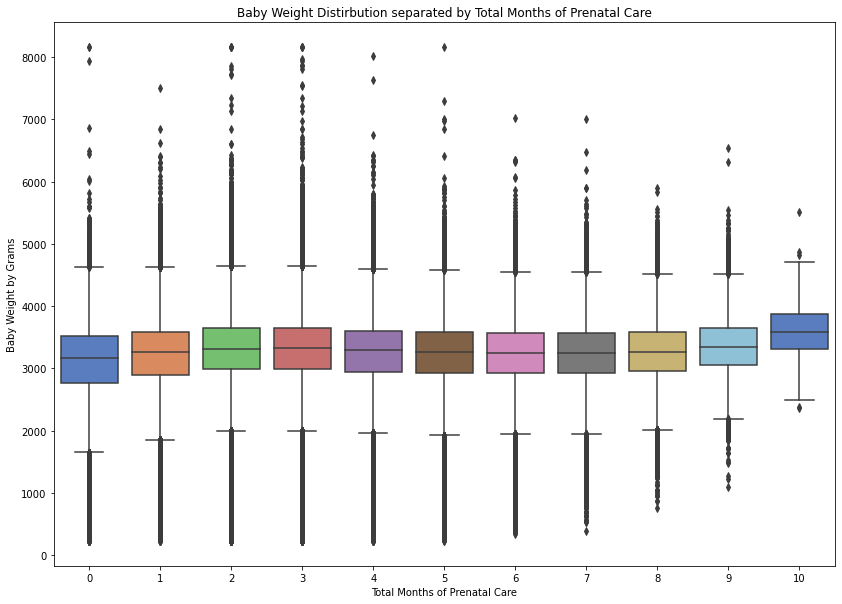

In [22]:
plt.figure(figsize=(14,10))
sns.boxplot(x='PRECARE',y='DBWT',data=df, palette = 'muted')
plt.title('Baby Weight Distirbution separated by Total Months of Prenatal Care')
plt.ylabel('Baby Weight by Grams')
plt.xlabel('Total Months of Prenatal Care')
plt.savefig('figure6.png')

In [23]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
_result = pairwise_tukeyhsd(df['DBWT'],df['PRECARE'], alpha = 0.05/11)
_result._results_table

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,114.0501,0.001,105.1562,122.944,True
0,2,213.2735,0.001,205.6563,220.8908,True
0,3,216.9362,0.001,209.2479,224.6244,True
0,4,173.9,0.001,165.4755,182.3244,True
0,5,145.8578,0.001,136.4799,155.2357,True
0,6,144.4195,0.001,133.9428,154.8961,True
0,7,153.5684,0.001,142.3887,164.7482,True
0,8,188.4338,0.001,176.179,200.6885,True
0,9,283.3919,0.001,265.974,300.8098,True
0,10,514.8688,0.001,392.6858,637.0517,True


In [24]:
df['PRECARE'].mean()

2.8458983567457485

In [25]:
df['PRECARE'].std()

1.5107559750478659

### Total Prenatal Visits

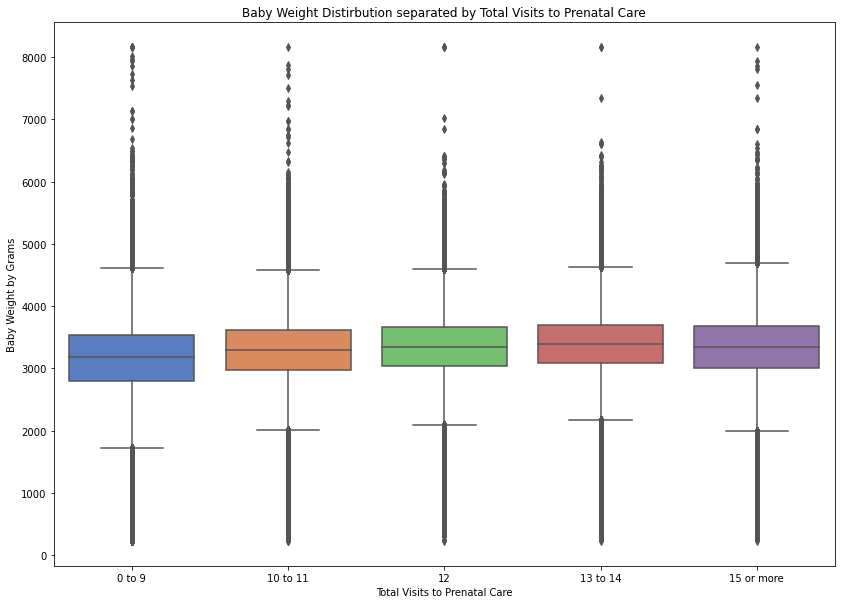

In [26]:
df['PREVIS_cat'] = pd.qcut(df['PREVIS'],q=5,labels=['0 to 9','10 to 11','12','13 to 14', '15 or more'])
plt.figure(figsize=(14,10))
sns.boxplot(x='PREVIS_cat',y='DBWT',data=df, palette = 'muted')
plt.title('Baby Weight Distirbution separated by Total Visits to Prenatal Care')
plt.ylabel('Baby Weight by Grams')
plt.xlabel('Total Visits to Prenatal Care')
plt.savefig('figure7.png')

In [27]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
_result = pairwise_tukeyhsd(df['DBWT'],df['PREVIS_cat'], alpha = 0.05/5)
_result._results_table

group1,group2,meandiff,p-adj,lower,upper,reject
0 to 9,10 to 11,175.8557,0.001,173.0373,178.6742,True
0 to 9,12,236.897,0.001,233.7486,240.0454,True
0 to 9,13 to 14,283.2431,0.001,280.2117,286.2745,True
0 to 9,15 or more,225.4317,0.001,222.294,228.5694,True
10 to 11,12,61.0413,0.001,57.8202,64.2624,True
10 to 11,13 to 14,107.3874,0.001,104.2805,110.4942,True
10 to 11,15 or more,49.576,0.001,46.3653,52.7866,True
12,13 to 14,46.3461,0.001,42.9371,49.7551,True
12,15 or more,-11.4653,0.001,-14.9692,-7.9615,True
13 to 14,15 or more,-57.8114,0.001,-61.2105,-54.4123,True


In [28]:
df['PREVIS'].mean()

11.235693425502276

In [29]:
df['PREVIS'].std()

4.297913164275282

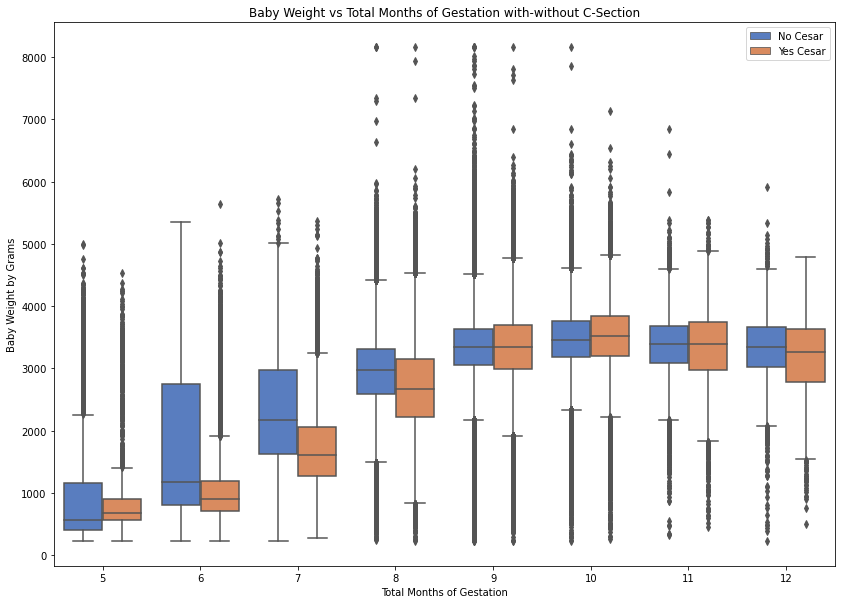

In [30]:
fig, ax = plt.subplots(figsize=(14,10))
sns.boxplot(x='pregnancy_length',y='DBWT',data=_X, hue = 'RDMETH_REC_3',palette = 'muted', ax=ax)
handles, _ = ax.get_legend_handles_labels()
ax.legend(loc='upper right', handles = handles, labels = ['No Cesar', 'Yes Cesar'])
ax.set_title('Baby Weight vs Total Months of Gestation with-without C-Section')
ax.set_ylabel('Baby Weight by Grams')
ax.set_xlabel('Total Months of Gestation')
plt.savefig('figure8.png')

### Chi2 Test 
Curious to see if there is a proportion difference of gender babies relative to race

In [31]:
_table = pd.crosstab(df['SEX'], df['MRAVE6'])
_table

MRAVE6,1,2,3,4,5,6
SEX,,,,,,
F,1267368,268083,16020,115783,5251,44790
M,1326775,275104,16631,123333,5368,47306


In [32]:
stats.chi2_contingency(_table)

(73.02705571761017,
 2.3995882513610437e-14,
 5,
 array([[1268549.91189306,  265621.37129351,   15966.51501988,
          116929.0130622 ,    5192.74824649,   45035.44048486],
        [1325593.08810694,  277565.62870649,   16684.48498012,
          122186.9869378 ,    5426.25175351,   47060.55951514]]))

### Last Minute Feature Engineering

In [33]:
_X['RDMETH_REC_3_pregnancy_length_cat_Early'] = _X['RDMETH_REC_3'] * _X['pregnancy_length_cat_Early']

# 3. Model Approach
A good amount of the time was spent feature selecting the variables that had a greater p-value score of 0.05. <br>
I first used all the columns from my dataframe and popped the columns that failed to reject the hypothesis that coefficients are not 0

In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
_X_columns = _X.columns
_X[continuous_columns] = scaler.fit_transform(_X[continuous_columns])
_X = pd.DataFrame(data=_X, columns = _X_columns)

### Feature Selection
selecting columns that have lower than 0.05 p score from ols.summary()

In [35]:
_new_columns = [
#     'first_birth',
#  'first_pregnancy',
#  'first_natal',
 'MAGER',
#  'pregnancy_length',
#  'WTGAIN_div_MOM_weight',
 'WTGAIN_div_length',
 'PRECARE',
 'PREVIS',
#  'PWgt_R',
 'BMI_log',
 'M_Ht_In',
 'MOM_weight',
 'WTGAIN',
 'WT_percent_gain',
#  'BMI',
 'ATTEND_1',
#  'ATTEND_2',
 'ATTEND_3',
 'ATTEND_4',
#  'ATTEND_5',
#  'ATTEND_9',
#  'BFACIL_1',
 'BFACIL_2',
 'BFACIL_3',
#  'BFACIL_4',
 'BFACIL_5',
#  'BFACIL_6',
#  'BFACIL_7',
#  'BFACIL_9',
#  'smoked_Daily',
 'smoked_None',
#  'smoked_Unknown',
#  'DOB_MM_1',
#  'DOB_MM_2',
#  'DOB_MM_3',
#  'DOB_MM_4',
#  'DOB_MM_5',
#  'DOB_MM_6',
#  'DOB_MM_7',
#  'DOB_MM_8',
#  'DOB_MM_9',
#  'DOB_MM_10',
#  'DOB_MM_11',
#  'DOB_MM_12',
#  'DMAR_0',
#  'DMAR_1',
 'DMAR_2',
 'FHISPX_0',
#  'FHISPX_1',
#  'FHISPX_2',
#  'FHISPX_3',
#  'FHISPX_4',
#  'FHISPX_5',
#  'FHISPX_6',
#  'FHISPX_9',
#  'FEDUC_1',
#  'FEDUC_2',
#  'FEDUC_3',
#  'FEDUC_4',
#  'FEDUC_5',
 'FEDUC_6',
#  'FEDUC_7',
#  'FEDUC_8',
#  'FEDUC_9',
 'FRACE6_1',
#  'FRACE6_2',
#  'FRACE6_3',
 'FRACE6_4',
#  'FRACE6_5',
#  'FRACE6_6',
#  'FRACE6_9',
#  'plural_delivery_No',
 'plural_delivery_Yes',
#  'IP_GON_N',
#  'IP_GON_U',
#  'IP_GON_Y',
 'LD_INDL_N',
#  'LD_INDL_U',
#  'LD_INDL_Y',
#  'T35AGE_older_0',
 'T35AGE_older_1',
#  'MAR_IMP_1',
 'MBSTATE_REC_1',
#  'MBSTATE_REC_2',
#  'MBSTATE_REC_3',
 'MEDUC_1',
#  'MEDUC_2',
 'MEDUC_3',
 'MEDUC_4',
 'MEDUC_5',
 'MEDUC_6',
 'MEDUC_7',
#  'MEDUC_8',
#  'MEDUC_9',
 'MHISPX_0',
#  'MHISPX_1',
 'MHISPX_2',
#  'MHISPX_3',
#  'MHISPX_4',
#  'MHISPX_5',
 'MHISPX_6',
#  'MHISPX_9',
#  'MRAVE6_1',
 'MRAVE6_2',
#  'MRAVE6_3',
 'MRAVE6_4',
#  'MRAVE6_5',
 'MRAVE6_6',
#  'MTRAN_N',
#  'MTRAN_U',
 'MTRAN_Y',
 'NO_INFEC_0',
#  'NO_INFEC_1',
#  'NO_INFEC_9',
 'NO_MMORB_0',
#  'NO_MMORB_1',
#  'NO_MMORB_9',
 'NO_RISKS_0',
#  'NO_RISKS_1',
#  'NO_RISKS_9',
#  'PAY_1',
#  'PAY_2',
#  'PAY_3',
#  'PAY_4',
#  'PAY_5',
#  'PAY_6',
 'PAY_8',
#  'PAY_9',
 'PAY_REC_1',
#  'PAY_REC_2',
#  'PAY_REC_3',
#  'PAY_REC_4',
#  'PAY_REC_9',
#  'PRIORDEAD_cat_None',
#  'PRIORDEAD_cat_Unknown',
 'PRIORDEAD_cat_Yes',
#  'PRIORLIVE_cat_None',
#  'PRIORLIVE_cat_Unknown',
 'PRIORLIVE_cat_Yes',
#  'PRIORTERM_cat_None',
#  'PRIORTERM_cat_Unknown',
#  'PRIORTERM_cat_Yes',
#  'RDMETH_REC_1',
#  'RDMETH_REC_2',
 'RDMETH_REC_3',
#  'RDMETH_REC_4',
#  'RDMETH_REC_5',
#  'RDMETH_REC_6',
#  'RDMETH_REC_9',
 'RESTATUS_1',
#  'RESTATUS_2',
#  'RESTATUS_3',
#  'RESTATUS_4',
 'RF_CESAR_N',
#  'RF_CESAR_U',
#  'RF_CESAR_Y',
#  'SEX_F',
 'SEX_M',
#  'MAGER_cat_Adult',
 'MAGER_cat_Minor',
 'pregnancy_length_cat_10',
 'pregnancy_length_cat_8',
 'pregnancy_length_cat_9',
 'pregnancy_length_cat_Early',
#  'pregnancy_length_cat_Late',
 'MAGER_smoked_Daily',
 'NO_RISKS_1_length',
 'RDMETH_REC_3_length',
 'RDMETH_REC_1_length',
 'ATTEND_1_length',
 'MRAVE6_1_FRACE6_1',
 'BFACIL_1_length',
 'BMI_log_length',
#  'M_Ht_In_length',
 'LD_INDL_N_length',
 'MTRAN_Y_length',
 'PRECARE_length',
 'PREVIS_length',
 'MOM_weight_length',
 'RDMETH_REC_3_pregnancy_length_cat_9',
 'RF_CESAR_Y_pregnancy_length_cat_9',
 'pregnancy_length_sqrt',
'RDMETH_REC_3_pregnancy_length_cat_Early'
]

### Ordinary Least Squares

In [36]:

_X['DBWT'] = y
from statsmodels.formula.api import ols
formula = 'DBWT~'+'+'.join(_new_columns)
model = ols(formula=formula, data=_X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DBWT   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                 3.000e+04
Date:                Fri, 31 Jul 2020   Prob (F-statistic):               0.00
Time:                        08:56:14   Log-Likelihood:            -2.6504e+07
No. Observations:             3511812   AIC:                         5.301e+07
Df Residuals:                 3511740   BIC:                         5.301e+07
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                3216.0039     14.506    221.696      0.000    3187.572    3244.436
MAGER                                      -7.4793      0.421    -17.761      0.000      -8.305      -6.654
WTGAIN_div_length                         134.9631      2.916     46.281      0.000     129.248     140.679
PRECARE                                   429.2832      3.095    138.712      0.000     423.218     435.349
PREVIS                                    240.3137      3.140     76.536      0.000     234.160     246.468
BMI_log                                   394.6952      7.806     50.566      0.000     379.397     409.994
M_Ht_In                                   131.3858      0.734    178.987      0.000     129.947     132.824
MOM_weight                               -346.6632      7.755    -44.701      0.000    -361.863    -331.464
WTGAIN                                   -115.5577      3.109    -37.166      0.000    -121.652    -109.464
WT_percent_gain                            91.5771      1.255     72.972      0.000      89.117      94.037
ATTEND_1                                 -152.8303      8.891    -17.190      0.000    -170.256    -135.405
ATTEND_3                                   48.5473      1.170     41.477      0.000      46.253      50.841
ATTEND_4                                   51.6190      3.539     14.587      0.000      44.683      58.555
BFACIL_2                                  138.1555      6.672     20.708      0.000     125.079     151.232
BFACIL_3                                  186.7486      6.553     28.499      0.000     173.905     199.592
BFACIL_5                                  120.2240      9.984     12.041      0.000     100.655     139.793
smoked_None                                31.8138      3.095     10.278      0.000      25.747      37.881
DMAR_2                                    -20.4238      0.649    -31.451      0.000     -21.697     -19.151
FHISPX_0                                   30.2659      0.728     41.563      0.000      28.839      31.693
FEDUC_6                                    12.9653      0.725     17.874      0.000      11.544      14.387
FRACE6_1                                   55.6504      1.697     32.796      0.000      52.325      58.976
FRACE6_4                                  -85.1853      1.907    -44.669      0.000     -88.923     -81.448
plural_delivery_Yes                      -680.7277      2.244   -303.338      0.000    -685.126    -676.329
LD_INDL_N                                -153.2797      8.190    -18.715      0.000    -169.332    -137.228
T35AGE_older_1                             -6.4804      0.905     -7.164      0.000      -8.253      -4.707
MBSTATE_REC_1                             -56.2093      0.7

In [37]:
_X

,first_birth,first_live_birth,first_natal,pregnancy_length_sqrt,MAGER,pregnancy_length,WTGAIN_div_MOM_weight,WTGAIN_div_length,PRECARE,PREVIS,PWgt_R,BMI_log,M_Ht_In,MOM_weight,WTGAIN,WT_percent_gain,BMI,ATTEND_1,ATTEND_2,ATTEND_3,ATTEND_4,ATTEND_5,ATTEND_9,BFACIL_1,BFACIL_2,BFACIL_3,BFACIL_4,BFACIL_5,BFACIL_6,BFACIL_7,BFACIL_9,smoked_Daily,smoked_None,smoked_Unknown,DOB_MM_1,DOB_MM_2,DOB_MM_3,DOB_MM_4,DOB_MM_5,DOB_MM_6,DOB_MM_7,DOB_MM_8,DOB_MM_9,DOB_MM_10,DOB_MM_11,DOB_MM_12,DMAR_0,DMAR_1,DMAR_2,FHISPX_0,FHISPX_1,FHISPX_2,FHISPX_3,FHISPX_4,FHISPX_5,FHISPX_6,FHISPX_9,FEDUC_1,FEDUC_2,FEDUC_3,FEDUC_4,FEDUC_5,FEDUC_6,FEDUC_7,FEDUC_8,FEDUC_9,FRACE6_1,FRACE6_2,FRACE6_3,FRACE6_4,FRACE6_5,FRACE6_6,FRACE6_9,plural_delivery_No,plural_delivery_Yes,IP_GON_N,IP_GON_U,IP_GON_Y,LD_INDL_N,LD_INDL_U,LD_INDL_Y,T35AGE_older_0,T35AGE_older_1,MAR_IMP_0,MAR_IMP_1,MBSTATE_REC_1,MBSTATE_REC_2,MBSTATE_REC_3,MEDUC_1,MEDUC_2,MEDUC_3,MEDUC_4,MEDUC_5,MEDUC_6,MEDUC_7,MEDUC_8,MEDUC_9,MHISPX_0,MHISPX_1,MHISPX_2,MHISPX_3,MHISPX_4,MHISPX_5,MHISPX_6,MHISPX_9,MRAVE6_1,MRAVE6_2,MRAVE6_3,MRAVE6_4,MRAVE6_5,MRAVE6_6,MTRAN_N,MTRAN_U,MTRAN_Y,NO_INFEC_0,NO_INFEC_1,NO_INFEC_9,NO_MMORB_0,NO_MMORB_1,NO_MMORB_9,NO_RISKS_0,NO_RISKS_1,NO_RISKS_9,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_8,PAY_9,PAY_REC_1,PAY_REC_2,PAY_REC_3,PAY_REC_4,PAY_REC_9,PRIORDEAD_cat_None,PRIORDEAD_cat_Unknown,PRIORDEAD_cat_Yes,PRIORLIVE_cat_None,PRIORLIVE_cat_Unknown,PRIORLIVE_cat_Yes,PRIORTERM_cat_None,PRIORTERM_cat_Unknown,PRIORTERM_cat_Yes,RDMETH_REC_1,RDMETH_REC_2,RDMETH_REC_3,RDMETH_REC_4,RDMETH_REC_5,RDMETH_REC_6,RDMETH_REC_9,RESTATUS_1,RESTATUS_2,RESTATUS_3,RESTATUS_4,RF_CESAR_N,RF_CESAR_U,RF_CESAR_Y,SEX_F,SEX_M,MAGER_cat_Adult,MAGER_cat_Minor,pregnancy_length_cat_10,pregnancy_length_cat_8,pregnancy_length_cat_9,pregnancy_length_cat_Early,pregnancy_length_cat_Late,MAGER_smoked_Daily,NO_RISKS_1_length,RDMETH_REC_3_length,RDMETH_REC_1_length,ATTEND_1_length,MRAVE6_1_FRACE6_1,BFACIL_1_length,BMI_log_length,M_Ht_In_length,LD_INDL_N_length,MTRAN_Y_length,PRECARE_length,PREVIS_length,MOM_weight_length,RDMETH_REC_3_pregnancy_length_cat_9,RF_CESAR_Y_pregnancy_length_cat_9,DBWT,RDMETH_REC_3_pregnancy_length_cat_Early
0,0,0,0,0.065945,0.168017,0.047694,0.124143,0.735641,0.102003,-0.752852,0.749368,0.656386,0.664594,0.754039,0.761503,0.126366,0.532551,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,-0.289485,0.662438,-0.470176,0.706982,0.492763,1,0.136191,0.491592,0.937258,0.624093,-0.066341,0.109345,-0.731369,0.747001,0,0,3657,0
1,0,0,1,0.065945,-0.177639,0.047694,0.598049,1.844546,1.425844,1.341187,1.350595,0.556360,2.431691,1.352256,1.889076,0.599348,0.428200,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,-0.289485,-1.471427,-0.470176,0.706982,0.492763,1,0.136191,0.422326,0.937258,0.624093,-0.066341,1.426922,1.301343,1.327572,0,0,3470,0
2,0,0,1,-1.409771,-1.041778,-1.423152,-1.764466,-1.938777,1.425844,-1.218194,-0.501185,-0.465885,-0.042244,-0.498878,-1.957936,-1.764491,-0.510957,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,-0.289485,0.425342,-0.470176,0.474646,-2.028291,0,-0.629970,-1.341776,-1.057192,0.375953,-0.066341,1.060928,-1.333654,-0.826775,0,0,3140,0
3,0,0,1,1.461713,-0.523295,1.518540,0.296109,0.820440,-0.559917,0.410503,0.989859,0.740323,1

In [38]:
_X.drop(columns=['DBWT'],inplace=True)
_X.shape

(3511812, 185)

In [39]:
_X[continuous_columns] = scaler.inverse_transform(_X[continuous_columns])


In [41]:
_X = _X.copy()
X_train, X_test, y_train, y_test = train_test_split(_X, y, random_state = 42, test_size=0.2)
scaler = StandardScaler()
X_train[continuous_columns] = scaler.fit_transform(X_train[continuous_columns])
X_test[continuous_columns] = scaler.transform(X_test[continuous_columns])

C:\Users\albert\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\albert\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\albert\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

### Linear Regression
cross validating to see rmse, but more importantly looking to see if R2 improved

In [42]:
linreg = LinearRegression()
linreg.fit(X_train[_new_columns],y_train)
y_train_linreg = linreg.predict(X_train[_new_columns])
np.sqrt(metrics.mean_squared_error(y_train, y_train_linreg))

458.78927543521553

In [43]:
y_test_linreg = linreg.predict(X_test[_new_columns])
np.sqrt(metrics.mean_squared_error(y_test, y_test_linreg))

457.88570893448804

In [45]:
linreg.score(X_test[_new_columns],y_test)

0.378653213442658

### LassoCV
cross validating to see rmse, but more importantly looking to see if R2 improved

In [46]:
lasso_cv = LassoCV(cv=5, random_state=42, verbose=1)
lasso_cv.fit(X_train[_new_columns], y_train)
y_train_lasso = lasso_cv.predict(X_train[_new_columns])
np.sqrt(metrics.mean_squared_error(y_train, y_train_lasso))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished
C:\Users\albert\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1404942531.6297607, tolerance: 94958994.79875709
  positive)


459.56450847999463

In [47]:
y_test_lasso = lasso_cv.predict(X_test[_new_columns])
np.sqrt(metrics.mean_squared_error(y_test, y_test_lasso))

458.61005898777387

In [48]:
lasso_cv.score(X_test[_new_columns],y_test)

0.37668578548315934

# Key Insights

**RDMETH_REC_3** : -1389.8296 <br>
**plural_delivery_Yes** :-680.7277 <br>
**PRECARE** : 429.2832 <br>
**PREVIS** : 240.3137 <br>
**MTRAN_Y** : -777.0932 <br>
**SEX_M** : 116.4329 <br>
**smoked_None** : 31.8138 <br>